# Job Search: The Case of IID Offers

Fall semester 2018

#### John Stachurski

First some imports and LaTeX related commands.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from numba import njit, vectorize

In [2]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [3]:
n, p = 40, 0.5
pmf = binom.pmf(range(n), n, p)

A class to store primitives and a guess of the value function.

In [4]:
class JobSearchDiscrete:
    
    def __init__(self, 
                 wage_vals=np.arange(n),   # possible wage values
                 wage_probs=pmf,  # pmf for wages
                 β=0.96,        # discount factor
                 c=10):          # unemployment compensation
        
        self.wage_vals = wage_vals
        self.wage_probs = wage_probs
        self.β, self.c = β, c
        
        self.v_guess = np.ones_like(wage_vals)

A function factory that builds a jitted Bellman operator.

In [5]:
def bellman_operator_factory(jsd):
    
    wage_vals, wage_probs = jsd.wage_vals, jsd.wage_probs
    β, c = jsd.β, jsd.c
    
    @njit
    def bellman(v):
        new_v = np.empty_like(v)
        for i, w in enumerate(wage_vals):
            stop_val = w / (1 - β)
            continue_val = c + β * v @ wage_probs
            new_v[i] = max(stop_val, continue_val)
        return new_v
            
    return bellman

Some tests.

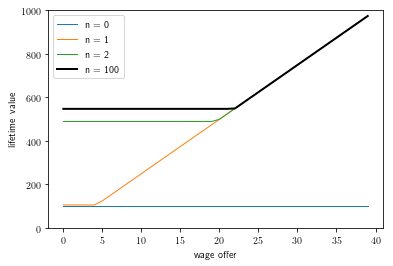

In [6]:
jsd = JobSearchDiscrete()

v = jsd.v_guess * 100
T = bellman_operator_factory(jsd)

fig, ax = plt.subplots()

k = 3
for i in range(k):
    ax.plot(jsd.wage_vals, v, lw=1, label=f"n = {i}")
    v = T(v)

for i in range(100-k):
    v = T(v)
ax.plot(jsd.wage_vals, v, 'k-', lw=2.0, label=f"n = 100")

ax.set_ylim((0, 1000))

ax.set_xlabel("wage offer")
ax.set_ylabel("lifetime value")

ax.legend()

plt.show()

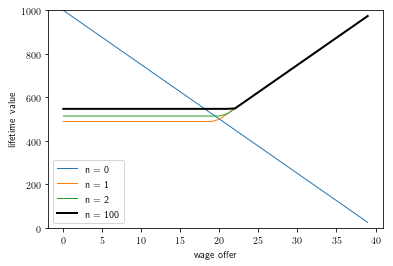

In [7]:
jsd = JobSearchDiscrete()

v = 1000 - 25 * jsd.wage_vals
T = bellman_operator_factory(jsd)

fig, ax = plt.subplots()

k = 3
for i in range(k):
    ax.plot(jsd.wage_vals, v, lw=1, label=f"n = {i}")
    v = T(v)

for i in range(100-k):
    v = T(v)
ax.plot(jsd.wage_vals, v, 'k-', lw=2.0, label=f"n = 100")

ax.set_ylim((0, 1000))

ax.set_xlabel("wage offer")
ax.set_ylabel("lifetime value")

ax.legend()

plt.show()

#### Computing the fixed point

In [8]:
def iterate(jsd, iter_max=500, tol=1e-6):
    
    T = bellman_operator_factory(jsd)
    v = jsd.v_guess
    
    i = 1
    error = tol + 1
    while error > tol and i <= iter_max:
        new_v = T(v)
        error = np.max(np.abs(new_v - v))
        i += 1
        v = new_v
        
    if i == iter_max:
        print("Warning: iteration hit upper bound")
    else:
        print(f"Converged in {i} iterations")
        
    return v
    

In [9]:
jsd = JobSearchDiscrete()

In [10]:
v_star = iterate(jsd)

Converged in 13 iterations


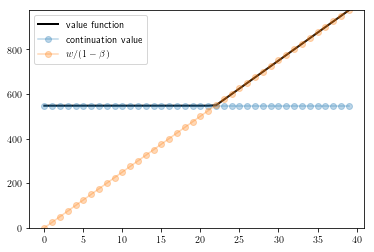

In [11]:
fig, ax = plt.subplots()

ax.plot(jsd.wage_vals, v_star, 'k-', lw=2.0, label="value function")

cont_val = jsd.c + jsd.β * v_star @ jsd.wage_probs

ax.plot(jsd.wage_vals, 
        cont_val * np.ones(n), 
        '-o', 
        alpha=0.3,
        label="continuation value")

ax.plot(jsd.wage_vals,
        jsd.wage_vals / (1 - jsd.β),
        '-o',
        alpha=0.3,
        label="$w/(1 - \\beta)$")

ax.set_ylim(0, v_star.max())
ax.legend()

plt.show()

In [12]:
jsd = JobSearchDiscrete()
wage_vals, wage_probs = jsd.wage_vals, jsd.wage_probs
β, c = jsd.β, jsd.c

### Rearranging the Bellman operator

Here's an implementation of the second approach, which avoids direct calculation of the value function.

In [ ]:
@vectorize
def g(h):
    e = np.maximum(wage_vals / (1 - β), h)   
    return c + β * e @ wage_probs

Let's have a look at the function $g$.

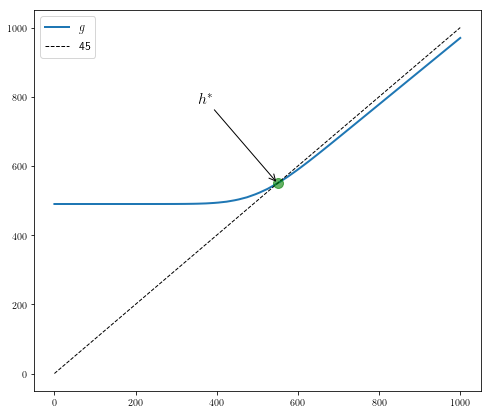

In [18]:
h_grid = np.linspace(0, max(c, n) / (1 - β), 100)

fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(h_grid, g(h_grid), lw=2.0, label="$g$")
ax.plot(h_grid, h_grid, 'k--', lw=1.0, label="45")

ax.legend(fontsize=12)


hs = 100
for i in range(100):
    hs = g(hs)
ax.plot(hs, hs, 'go', ms=10, alpha=0.6)

ax.annotate(r'$h^*$', 
         xy=(hs, hs),
         xycoords='data',
         xytext=(-80, 80),
         textcoords='offset points',
         fontsize=16,
         arrowprops=dict(arrowstyle="->"))

plt.show()

Here's the continuation value and the fixed point.

In [25]:
hs

549.894197499972

In [26]:
w_star = hs * (1 - β)

In [27]:
w_star

21.995767899998903

Let's recreate the value function from our knowledge of the continuation value.

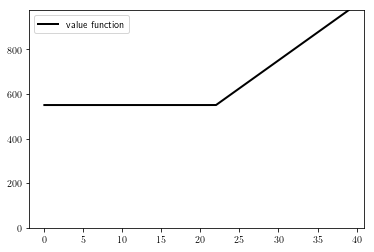

In [29]:
fig, ax = plt.subplots()

vhat = np.maximum(wage_vals / (1 - β), hs)

ax.plot(wage_vals, vhat, 'k-', lw=2.0, label="value function")
ax.set_ylim(0, v_star.max())
ax.legend()

plt.show()